# ECON 220C Part II Homework 4

## Productivity Shocks in the Three Equation Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set parameters
beta = 0.99
sigma = 1
kappa = 0.1
rho_a = 0.8
phi_pi = 1.5
gamma = 1
varphi = 1 # Why

In [3]:
# Define the number of time periods
T = 20

# Initialize arrays for the variables
a_t = np.zeros(T+1)
y_t = np.zeros(T)
pi_t = np.zeros(T)
y_flex_t = np.zeros(T)
y_gap_t = np.zeros(T)
i_t = np.zeros(T)
er_t1 = np.zeros(T)
n_t = np.zeros(T)

In [4]:
# Compute the eta coefficients
eta_pia = kappa * (1-rho_a) * (1+varphi) / (gamma+varphi) / (kappa*sigma*(rho_a-phi_pi) - (1-rho_a)*(1-beta*rho_a))
eta_ya = sigma * (rho_a-phi_pi) / (1-rho_a) * eta_pia
eta_ia = phi_pi * eta_pia
# eta_pia, eta_ya, eta_ia

In [5]:
# Impose a one-unit shock to a_t at t=0
a_t[0] = 1

# Calculate the values over time
for t in range(T):
    y_t[t] = eta_ya * a_t[t]
    pi_t[t] = eta_pia * a_t[t]
    y_flex_t[t] = (1 + varphi) / (gamma + varphi) * a_t[t]
    y_gap_t[t] = y_t[t] - y_flex_t[t]
    i_t[t] = eta_ia * a_t[t]
    er_t1[t] = (eta_ia - eta_pia * rho_a) * rho_a * a_t[t]
    n_t[t] = y_t[t] - a_t[t]
    a_t[t+1] = rho_a * a_t[t]

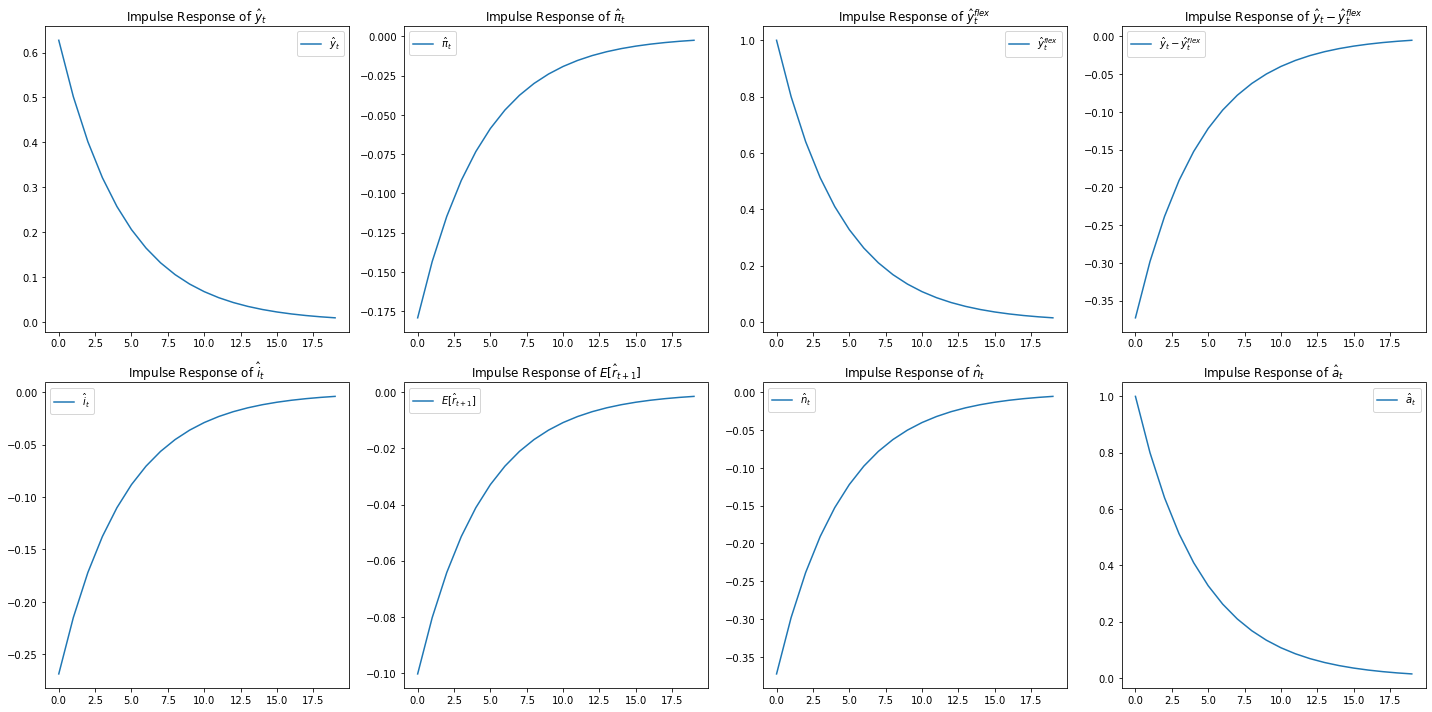

In [6]:
# Plot IRFs
time = np.arange(T)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

axes[0, 0].plot(time, y_t, label='$\hat{y}_t$')
axes[0, 0].set_title('Impulse Response of $\hat{y}_t$')
axes[0, 0].legend()

axes[0, 1].plot(time, pi_t, label='$\hat{\pi}_t$')
axes[0, 1].set_title('Impulse Response of $\hat{\pi}_t$')
axes[0, 1].legend()

axes[0, 2].plot(time, y_flex_t, label='$\hat{y}_t^{flex}$')
axes[0, 2].set_title('Impulse Response of $\hat{y}_t^{flex}$')
axes[0, 2].legend()

axes[0, 3].plot(time, y_gap_t, label='$\hat{y}_t - \hat{y}_t^{flex}$')
axes[0, 3].set_title('Impulse Response of $\hat{y}_t - \hat{y}_t^{flex}$')
axes[0, 3].legend()

axes[1, 0].plot(time, i_t, label='$\hat{i}_t$')
axes[1, 0].set_title('Impulse Response of $\hat{i}_t$')
axes[1, 0].legend()

axes[1, 1].plot(time, er_t1, label='$E[\hat{r}_{t+1}]$')
axes[1, 1].set_title('Impulse Response of $E[\hat{r}_{t+1}]$')
axes[1, 1].legend()

axes[1, 2].plot(time, n_t, label='$\hat{n}_t$')
axes[1, 2].set_title('Impulse Response of $\hat{n}_t$')
axes[1, 2].legend()

axes[1, 3].plot(time, a_t[0:-1], label='$\hat{a}_t$')
axes[1, 3].set_title('Impulse Response of $\hat{a}_t$')
axes[1, 3].legend()

plt.tight_layout()
plt.savefig('figs/q1_IRFs.png', dpi=300)

## Non-linear NK Model in Jupyter

In [7]:
from sequence_jacobian import simple, create_model
from sequence_jacobian.utilities.drawdag import drawdag

In [8]:
# Define blocks
@simple
def HH(c, n, varphi, gamma):
    wp = varphi * n + gamma * c
    return wp

@simple
def Firm(wp, n, pi, a, theta):
    y = a + n
    mu = a - wp
    b = theta*pi / (1-theta)
    return y, mu, b

@simple
def central_bank(pi, phi_pi):
    i = phi_pi * pi
    return i

@simple
def mkt_clearing(y, mu, c, i, pi, b, theta, gamma):
    euler = gamma * c + i - pi(+1) - gamma * c(+1)
    mkt_c = c - y
    b_clr = -(1-beta*theta)*mu+beta*theta*pi+beta*theta*b(+1)-b
    r = i - pi(+1)
    return euler, mkt_c, b_clr, r

nk = create_model([HH, Firm, central_bank, mkt_clearing], name="NK")

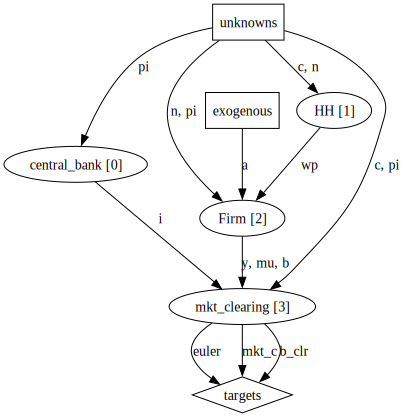

In [9]:
# Plot DAG
unknowns = ['c', 'n', 'pi']
targets = ['euler', 'mkt_c', 'b_clr']
inputs = ['a']

drawdag(nk, inputs, unknowns, targets, save="nk.png")

In [10]:
# Set parameters
beta = 0.99
gamma = 1
varphi = 1
chi = 1
epsilon = 10
rho_a = 0.8
phi_pi = 1.5
phi_y = 0

theta_list = np.array([0.0001, 0.25, 0.5, 0.75, 0.9999])

In [11]:
# Define a dictionary to store IRFs
irfs = {'y': [], 'ygap':[], 'n': [], 'i': [], 'r': [], 'mu': [], 'pi': [], 'c': []}

for theta in theta_list:
    
    # SS values
    calibration = {'a': 0, 'y': 0, 'r': 0, 'i': 0, 'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'varphi': varphi, 'theta': theta}

    # Solve for steady state (we know it, but running this routine helps us check for mistakes)
    unknowns_ss = {'c': 0, 'n': 0, 'pi': 0}
    targets_ss = {"euler": 0, 'mkt_c': 0, 'b_clr': 0}

    ss = nk.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="broyden_custom")

    # Check that we are in the steady state that we expect
    assert np.allclose(ss['pi'], 0)
    assert np.allclose(ss['euler'], 0)
    
    # Solve for NK
    G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)
    
    T, Tplot, impact, news = 300, 20, 0.01, 10
    da = np.empty((T, 1))
    da[:, 0] = impact * rho_a **np.arange(T)

    # Collecting impulse responses
    irfs['y'].append((G['y']['a']@da)[:Tplot])
    irfs['ygap'].append((G['y']['a']@da)[:Tplot] - (1+varphi)/(varphi+gamma)*da[:Tplot])
    irfs['n'].append((G['n']['a']@da)[:Tplot])
    irfs['i'].append((G['i']['a']@da)[:Tplot])
    irfs['r'].append((G['r']['a']@da)[:Tplot])
    irfs['mu'].append((G['mu']['a']@da)[:Tplot])
    irfs['pi'].append((G['pi']['a']@da)[:Tplot])
    irfs['c'].append((G['c']['a']@da)[:Tplot])



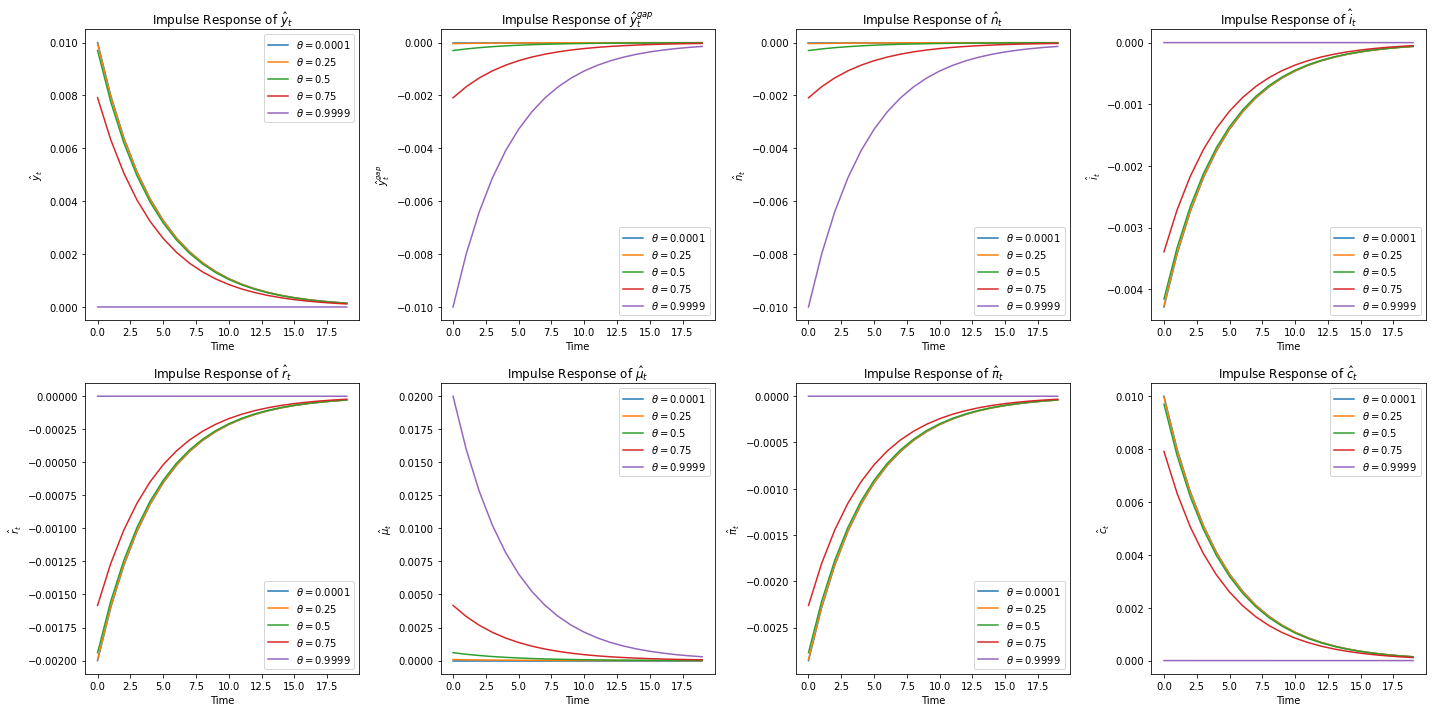

In [12]:
variable_names = {
    'y': '$\hat{y}_{t}$',
    'ygap': '$\hat{y}^{gap}_{t}$',
    'c': '$\hat{c}_{t}$',
    'pi': '$\hat{\\pi}_{t}$',
    'n': '$\hat{n}_{t}$',
    'i': '$\hat{i}_{t}$',
    'r': '$\hat{r}_{t}$',
    'mu': '$\hat{\\mu}_{t}$'
}

# Plot IRFs
variables = ['y', 'ygap', 'n', 'i', 'r', 'mu', 'pi', 'c']
time = np.arange(Tplot)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # Flatten the 2x4 grid to iterate easily

for idx, var in enumerate(variables):
    ax = axes[idx]
    for theta_idx, theta in enumerate(theta_list):
        ax.plot(time, irfs[var][theta_idx], label=f'$\\theta = {theta}$')
    ax.set_title(f'Impulse Response of {variable_names[var]}')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{variable_names[var]}')
    ax.legend()
    
plt.tight_layout()
plt.savefig('figs/q2_IRFs.png', dpi=300)